The original [notebook](https://www.kaggle.com/code/radek1/eda-an-overview-of-the-full-dataset) is done by Radek. I experimented to learn the techniques.

### import utils and otto dataset

In [ ]:
# make sure fastkaggle is install and imported
import os

try: import fastkaggle
except ModuleNotFoundError:
    os.system("pip install -Uq fastkaggle")

from fastkaggle import *

# use fastdebug.utils 
if iskaggle: os.system("pip install nbdev snoop")

if iskaggle:
    path = "../input/fastdebugutils0"
    import sys
    sys.path
    sys.path.insert(1, path)
    import utils as fu
    from utils import *
else: 
    from fastdebug.utils import *
    import fastdebug.utils as fu



# download (if necessary and return the path of the dataset)
home = "/Users/Natsume/Documents/fastdebug/kaggle_datasets/"
comp = 'otto-recommender-system' # https://www.kaggle.com/competitions/paddy-disease-classification/submissions
path = download_kaggle_dataset(comp, local_folder=home)#, install='fastai "timm>=0.6.2.dev0"')
# path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Let us read in the `train` and `test` datasets.

### rd: recsys - otto - get started - Read parquet file with `pd.read_parquet`

In [ ]:
train = pd.read_parquet('../input/otto-full-optimized-memory-footprint/train.parquet')
test = pd.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet')

Let us also read in the pickle file that will allow us to decipher the `type` information that has been encoded as integers to conserve memory.

In [ ]:
!pip install pickle5

import pickle5 as pickle

with open('../input/otto-full-optimized-memory-footprint/id2type.pkl', "rb") as fh:
    id2type = pickle.load(fh)

In [ ]:
train.shape, test.shape

((216716096, 4), (6928123, 4))

The `train` dataset contains 216716096 datapoints with `test` containing only 6928123.

Proportion of `test` to `train`:

In [ ]:
test.shape[0]/train.shape[0]

0.03196865912534711

The size of the test set is ~3.1% of the train set. This can give us an idea of how lightweight the inference is likely to be compared to training.

In [ ]:
train.head()

,session,aid,ts,type
0,0,1517085,1659304800,0
1,0,1563459,1659304904,0
2,0,1309446,1659367439,0
3,0,16246,1659367719,0
4,0,1781822,1659367871,0


### rd: recsys - otto - get started - find all the unique sessions, train.session.unique()

How many session are there in `train` and `test`?

In [ ]:
train.session.unique()
train.session.unique().shape

array([       0,        1,        2, ..., 12899776, 12899777, 12899778],
      dtype=int32)

(12899779,)

In [ ]:
train.session.unique().shape[0], test.session.unique().shape[0]

(12899779, 1671803)

In [ ]:
train.session.max() + 1

12899779

In [ ]:
test.session.unique().shape[0]/train.session.unique().shape[0]

0.12959935205091497

Seems the sessions in the test set are much shorter! Let's confirm this.

In [ ]:
test.head()

,session,aid,ts,type
0,12899779,59625,1661724000,0
1,12899780,1142000,1661724000,0
2,12899780,582732,1661724058,0
3,12899780,973453,1661724109,0
4,12899780,736515,1661724136,0


### rd: recsys - otto - get started - group 'aid' by 'session' and count, test.groupby('session')['aid'].count()

In [ ]:
test.groupby('session')['aid'].count()
train.groupby('session')['aid'].count()

session
12899779     1
12899780     5
12899781    11
12899782    70
12899783    11
            ..
14571577     1
14571578     1
14571579     1
14571580     1
14571581     1
Name: aid, Length: 1671803, dtype: int64

session
0           276
1            32
2            33
3           226
4            19
           ... 
12899774      2
12899775      2
12899776      2
12899777      2
12899778      2
Name: aid, Length: 12899779, dtype: int64

In [ ]:
test.groupby('session')['aid'].count().apply(np.log1p)

session
12899779    0.693147
12899780    1.791759
12899781    2.484907
12899782    4.262680
12899783    2.484907
              ...   
14571577    0.693147
14571578    0.693147
14571579    0.693147
14571580    0.693147
14571581    0.693147
Name: aid, Length: 1671803, dtype: float64

<AxesSubplot:>

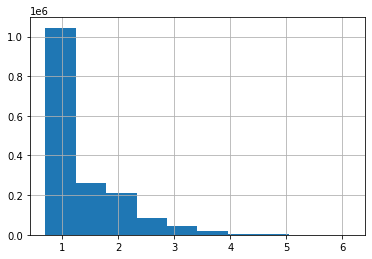

In [ ]:
test.groupby('session')['aid'].count().apply(np.log1p).hist()

<AxesSubplot:>

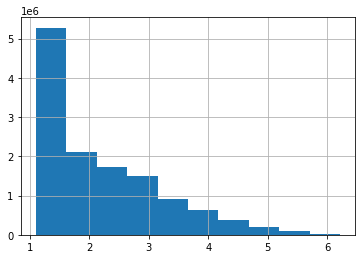

In [ ]:
train.groupby('session')['aid'].count().apply(np.log1p).hist()

### rd: recsys - otto - get started - return natural log and also be super accurate in floating point, train.groupby('session')['aid'].count().apply(np.log1p).hist()

In [ ]:
np.info(np.log1p) # see the notes for its actual usage here

log1p(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

Return the natural logarithm of one plus the input array, element-wise.

Calculates ``log(1 + x)``.

Parameters
----------
x : array_like
    Input values.
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broadcast to. If not provided or None,
    a freshly-allocated array is returned. A tuple (possible only as a
    keyword argument) must have length equal to the number of outputs.
where : array_like, optional
    This condition is broadcast over the input. At locations where the
    condition is True, the `out` array will be set to the ufunc result.
    Elsewhere, the `out` array will retain its original value.
    Note that if an uninitialized `out` array is created via the default
    ``out=None``, locations within it where the condition is False will
    re

### rd: recsys - otto - get started - train and test sessions have no time intersection, datetime.datetime.fromtimestamp, question

I have raised a [question](https://www.kaggle.com/code/radek1/eda-an-overview-of-the-full-dataset/comments#2024482) on why `/1000` in converting timestamp

There might be something at play here. Could the organizers have thrown us a curve ball and the train and test data are not from the same distribution?

Let's quickly look at timestamps.

In [ ]:
train.ts

0            1659304800
1            1659304904
2            1659367439
3            1659367719
4            1659367871
                ...    
216716091    1661723987
216716092    1661723976
216716093    1661723986
216716094    1661723983
216716095    1661723994
Name: ts, Length: 216716096, dtype: int32

In [ ]:
import datetime

datetime.datetime.fromtimestamp(train.ts.min()/1000), datetime.datetime.fromtimestamp(train.ts.max()/1000)
datetime.datetime.fromtimestamp(train.ts.min()), datetime.datetime.fromtimestamp(train.ts.max())

(datetime.datetime(1970, 1, 20, 4, 55, 4, 800000),
 datetime.datetime(1970, 1, 20, 5, 35, 23, 999000))

(datetime.datetime(2022, 7, 31, 22, 0),
 datetime.datetime(2022, 8, 28, 21, 59, 59))

In [ ]:
import datetime

datetime.datetime.fromtimestamp(test.ts.min()/1000), datetime.datetime.fromtimestamp(test.ts.max()/1000)
datetime.datetime.fromtimestamp(test.ts.min()), datetime.datetime.fromtimestamp(test.ts.max())

(datetime.datetime(1970, 1, 20, 5, 35, 24),
 datetime.datetime(1970, 1, 20, 5, 45, 28, 791000))

(datetime.datetime(2022, 8, 28, 22, 0),
 datetime.datetime(2022, 9, 4, 21, 59, 51))

Looks like we have temporally split data. The problem is that the data doesn't come from the same period. In most geographies the beginning of September is the start of the school year!

That is the period where people are coming back from vacation, commerce resumes after a slowdown during the vacation season.

The organizers are not making this easy for us 🙂

### rd: recsys - otto - get started - no new items in test, len(set(test.aid.tolist()) - set(train.aid.tolist()))

Let's see if there are any new items in the test set that were not see in train.

In [ ]:
len(set(test.aid.tolist()) - set(train.aid.tolist()))

0

### rd: recsys - otto - get started - train and test have different session length distributions, train.groupby('session')['aid'].count().describe()

So at least we have that going for us, no new items in the test set! 😊

I just scanned the forums really quickly and seems we have an answer as to why the session length differs between `train` and `test`!

First, let's look at the data more closely.

In [ ]:
train.groupby('session')['aid'].count().describe()

count    1.289978e+07
mean     1.679999e+01
std      3.357738e+01
min      2.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      1.500000e+01
max      5.000000e+02
Name: aid, dtype: float64

In [ ]:
test.groupby('session')['aid'].count().describe()

count    1.671803e+06
mean     4.144103e+00
std      8.215717e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      4.580000e+02
Name: aid, dtype: float64

### rd: recsys - otto - get started - define a session (a tracking period)

And here is the [key piece of information on the forums](https://www.kaggle.com/competitions/otto-recommender-system/discussion/363554#2015486).

Apparently, a session are all actions by a user in the tracking period. So naturally, if the tracking period is shorter, the sessions will also be shorter.

Maybe there is nothing amiss happening here.

### rd: recsys - otto - get started - train and test have no common sessions, train.session.max(), test.session.min()

In [ ]:
train.session.max(), test.session.min()

(12899778, 12899779)

An we see that the `session_ids` are not overlapping between `train` and `test` so it will be impossible to map the users (even if we have seen them before in train). We have to assume each session is from a different user.

Now that I know a bit more about the dataset, I can't wait to start playing around with it. This is shaping up to be a very interesting problem! 😊